# Biomechanical Simulation Lab
I Latin-American Summer School on Biomechanics and Mechanobiology. Instructor: Francisco Sahli - fsahli1@uc.cl

In this session, we will learn some basic concepts of finite elements and hyperelasticity focused in biomechanical materials. We will use the open source finite element enviroment FEnicS.

We first import some packages:
- dolfin: this is the finite element engine that we will be using. It is part of FeniCS
- matplotlib: used for plotting
- ufl: is also part of dolfin, we require only one function from here
- numpy: is a general scientific computing package

Dolfin generates and compiles C++ code in the back to speed up calculations and we need to set some compiler parameters

In [1]:
from dolfin import *
import matplotlib.pyplot as plt
from ufl import cofac
import numpy as np

parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"
parameters["form_compiler"]["quadrature_degree"] = 2


We also define some functions that will be useful and make the code look cleaner

In [29]:
#helper functions
def plot_beam(V, u, Z = None, P = None, component = 0):
    coords = V.tabulate_dof_coordinates()[::3,:]
    face_ind = np.where(coords[:,1] == 0.0)[0]
    disp = u.vector().get_local().reshape((-1,3))
    up_coords = coords + disp
    
    plt.figure(figsize = (10,5))
    plt.scatter(coords[face_ind,0],coords[face_ind,2], 9,'k')
    if Z is None or P is None:
        plt.scatter(up_coords[face_ind,0],up_coords[face_ind,2],25, 'red')
    else:
        P_project = project(P,Z)
        P_nodes = P_project.vector().get_local().reshape((-1,9))
        plt.scatter(up_coords[face_ind,0],up_coords[face_ind,2],25, c = P_nodes[face_ind,component])
        cbar = plt.colorbar()
        cbar.set_label('stress [kPa]')
        
    plt.xlabel('X [mm]')
    plt.ylabel('Z [mm]')
    plt.axis('equal')
    
def get_stress(Z, P, pos = [5.,0.5,0.5], component = 0):
    pos = np.array(pos)
    coords = Z.tabulate_dof_coordinates()[::9,:]
    dof_ind = np.argmin(np.linalg.norm(coords - pos, axis = 1))
    
    P_project = project(P,Z)
    P_nodes = P_project.vector().get_local().reshape((-1,9))
    
    return P_nodes[dof_ind, component]

def get_disp(V, u, pos = [10.,0.5,1.0], component = 2):
    pos = np.array(pos)
    coords = V.tabulate_dof_coordinates()[::3,:]
    dof_ind = np.argmin(np.linalg.norm(coords - pos, axis = 1))
    
    disp = u.vector().get_local().reshape((-1,3))
    
    return disp[dof_ind, component]


We are going to work with a simple beam geometry throughout this session. The dimensions are:
$$\rm L_x = 10 \hspace{1mm}mm, \hspace{2mm}L_y = L_z = 1\hspace{1mm}\rm{mm}$$

<img src="beam.png" width=500>

We will use the built-in `BoxMesh` function from dolfin to generate the beam. We specify the 2 opposite corners of the beam using a list of `Point`. We specify the number of division that we want on each direction with `nx, ny, nz`. We will start with a coarse mesh of 0.5 mm and later refine it to get more accurate results. Finally, we set the cell (element) type to hexahedron. 

In [25]:
nx = 20
ny = nz = 2

mesh = BoxMesh.create([Point(0.0,0.0,0.0),Point(10.0,1.0,1.0)],[nx,ny,nz],CellType.Type.hexahedron)

We create a vector function space `V` for our mesh, using Lagrange polynomials of degree 1. This will determine the type of element we will use. We also create a tensor function space `Z` to store and compute stress.
We then create the test and trail functions `v` and `du` and the function that will represent the displacements `u`

In [4]:
V = VectorFunctionSpace(mesh, "Lagrange", 1)
Z = TensorFunctionSpace(mesh, 'Lagrange', 1) # for stress visualization
du = TrialFunction(V)            # Incremental displacement
v  = TestFunction(V)             # Test function
u  = Function(V)                 # Displacement from previous iteration

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


We define the kinematics of the problem, specically the deformation gradient $$\mathbf{F} = \frac{d \mathbf{x}}{d \mathbf{X}} = \mathbf{I} + \frac{d \mathbf{u}}{d \mathbf{X}}$$
Since we will make multiple calls to this expression, we will define a function:

In [5]:
def def_grad(u):
    I = Identity(3)
    F = I + grad(u)
    return F

We will start with a neo-Hookean material with the following strain energy function:

$$W = \frac{\mu}{2}(I_1 - 3) - \mu\ln{J} + \frac{\lambda}{2}\ln(J)^2$$
where $\mu$ and $\lambda$ are the Lamé parameters, $I_1 = {\rm tr}(\mathbf{C})$ and $J = \det{\mathbf{F}}$. 

$\mathbf{C} = \mathbf{F}^t\mathbf{F}$ is the right Cauchy-Green deformation tensor. 

Define the strain energy function $W$ from the deformation gradient $\mathbf{F}$:

In [7]:
def W_neohook(F, mu = 1.0, lmbda = 10.0):
    C = F.T*F 
    J = det(F)
    I1 = tr(C)
    W = (mu/2)*(I1 - 3) - mu*ln(J) + (lmbda/2)*(ln(J))**2
    return W

We now define the total potential energy as volume integral over the entire body:
$$\Pi = \int_B W(\mathbf{F}) dV$$
In general, this term could include traction and body forces, but we will ignore them for now.
The variable `dx` represents a volume integral in FeniCS

In [8]:
F = def_grad(u)
F = variable(F) # this is used to compute stress later

W = W_neohook(F)

Pi = W*dx 

We start by simulating a traction test, where we clamp both ends of the bar and pull on one of them with a given displacement.

<img src="beam_bc.png" width=500>

To achieve this, we first need to write functions `left` and `right` to define the surfaces where the boundary conditions are applied. The term `on_boundary` is true when the nodes are at the boundary of the domain. The term `near(x[0], 0.0, tol)` specifies the location, which is the case of `left` is `0.0`. The vector `x` contains the (x,y,z) coordinates of the node, starting from `0`.

In [9]:
def left(x, on_boundary):
    tol = 1E-14
    return on_boundary and near(x[0], 0.0, tol)


def right(x, on_boundary):
    tol = 1E-14
    return on_boundary and near(x[0], 10.0, tol)


We then define the magnitude of the loads with the `Constant`s `c` and `r`. We use `Constant` here instead of the single value because we can update these quantities later without the need of redifining the entire model. We constraint the left side with `0.0` in every direction and on the right side we constraint the y and z directions and apply a 1 mm displacement in the x direction.

We finally define the left `bcl` and right `bcr` Dirichlet boundary conditions and create a list `bcs` with them:

In [10]:
c = Constant((0.0, 0.0, 0.0))
r = Constant((1.0,0.0,0.0))

bcl = DirichletBC(V, c, left)
bcr = DirichletBC(V, r, right)
bcs = [bcl, bcr]

We have completely defined our problem and we can now define our residual `G` as the directional (Gateaux) derivative of the potential energy `Pi` as $G = d\Pi(\mathbf{u};\mathbf{v}) = 0$. Since we are going to use Newton-Raphson solver for this problem, we also the need the need the Jacobian of `G`, `dG`, $dG = dG(\mathbf{u};d\mathbf{u})$. This is all handled automatically by FeniCS and we don't need to do all the derivations.

In [11]:
G = derivative(Pi, u, v)
dG = derivative(G, u, du)

We finally can solve the problem by simply calling `solve` and including the residual `G`, the displacement field `u`, the boundary conditions `bcs` and the Jacobian `dG`.

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


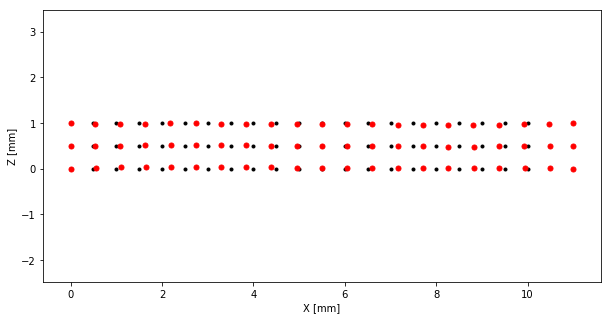

In [12]:
solve(G == 0, u, bcs, J=dG)
plot_beam(V,u)

We can also compute the 1st Piola-Kirchhoff stress as $\mathbf{P} = \frac{\delta W}{\delta \mathbf{F}}$ and plot $\mathbf{P}_{11}$.


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


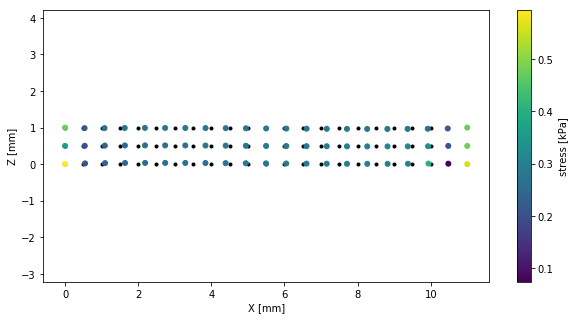

In [13]:
P = diff(W,F)
plot_beam(V,u,Z,P)

We can increase the displacement that we apply to the right end of the bar to 10 mm, by re-assigning the value of the `Constant` `r` and solve the problem again.

In [14]:
r.assign(Constant((0.0,10.0,0.0)))

solve(G == 0, u, bcs, J=dG)

plot_beam(V,u)

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2018.1.0
*** Git changeset:  948dc42cc4e06ed9227d0201ad50f94ac94cbf9f
*** -------------------------------------------------------------------------


### ERROR

We see that the solver failed to converge. This is very common in large deformation problems. The issue is that the initial guess of the solution (zero displacement) is too far away from the solution. One very widely used methodolody to remedy this problem is load stepping. Here, we apply the displacement in smaller steps and update the initial guess every time. To achieve this, we create a `for` loop that updated the value of `r` by an `increment`. We also store the displacement in `disp_neo` and stress at the center of the bar in `stress_neo`. We use the helper function `get_stress` for this.

1/10, displacement = 1.000000
2/10, displacement = 2.000000
3/10, displacement = 3.000000
4/10, displacement = 4.000000
5/10, displacement = 5.000000
6/10, displacement = 6.000000
7/10, displacement = 7.000000
8/10, displacement = 8.000000
9/10, displacement = 9.000000
10/10, displacement = 10.000000


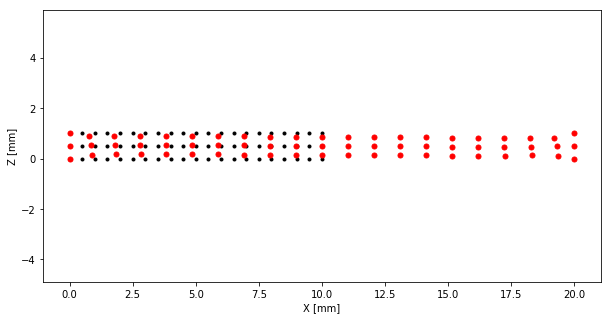

In [15]:
# reset solution
zeros = np.zeros_like(u.vector().get_local())
u.vector().set_local(zeros)

n_steps = 10
max_disp = 10.0 # this must float!!
increment = max_disp/n_steps

disp_neo = [0]
stress_neo = [0]

for i in range(n_steps):
    print('%i/%i, displacement = %f' % (i+1, n_steps,increment*(i+1)))
    r.assign(Constant((increment*(i+1),0.0,0.0)))
    solve(G == 0, u, bcs, J=dG)
    disp_neo.append(increment*(i+1))
    stress_neo.append(get_stress(Z,P))

plot_beam(V,u)

We see that the simulation now is able to converge. Since we compute multiple intermediate steps, we can also plot how the stress evolves as we increase the displacement

Text(0,0.5,'stress [kPa]')

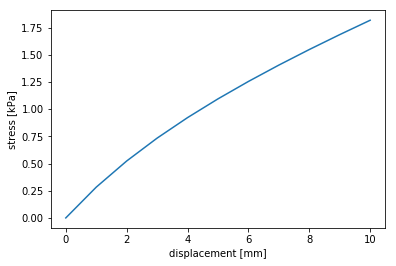

In [16]:
plt.plot(disp_neo,stress_neo)
plt.xlabel('displacement [mm]')
plt.ylabel('stress [kPa]')

## Guccione material model

We now switch to a more complex, biologically relevant material. The Guccione model [1] was developed specifically for cardiac tissue, to capture the exponential and anisotropic behavior observed in experiments. It is defined by the following strain energy function:
$$W_{ani} = \frac{C}{2}(e^Q - 1)$$ 
$$     Q = b_{f}\mathbf{E}_{11}^2 + b_{t}(\mathbf{E}_{22}^2 + \mathbf{E}_{33}^2 + \mathbf{E}_{23}^2 + \mathbf{E}_{32}^2) + b_{fs}(\mathbf{E}_{12}^2 + \mathbf{E}_{21}^2 + \mathbf{E}_{13}^2 + \mathbf{E}_{31}^2) $$

The tensor $\mathbf{E}$ is defined in a coordinate system that is aligned with the fibers of the cardiac tissue. We will define this system as `e1,e2,e3` in the code to project the tensor. In our case, we will consider that this is the x direction.

Here, we consider a nearly incompressible version, with $\mathbf{E} = \frac{1}{2}(\bar{\mathbf{C}} - \mathbf{I})$ and $\bar{\mathbf{C}} = J^{-\frac{2}{3}}\mathbf{C}$. For this reason, we need to add penalty term in the strain energy function to enforce the incompressibility:
$$ W_{inc} = \kappa(J^2 - 1 - 2\ln(J))$$
The total strain energy becomes $W_{guc} = W_{inc} + W_{ani}$.



In [17]:
def W_guccione(F):
    I = Identity(3)
    J = det(F)
    C = pow(J, -float(2)/3) * F.T*F
    E = 0.5*(C - I)

    CC  = 2.0

    # fully anisotropic
    bt  = Constant(8.0, name='bt')
    bf  = Constant(2.0, name='bf')
    bfs = Constant(4.0, name='bfs')
    kappa = Constant(100.0, name = 'kappa')

    e1 = as_vector([1.0,0.0,0.0])
    e2 = as_vector([0.0,1.0,0.0])
    e3 = as_vector([0.0,0.0,1.0])

    E11, E12, E13 = inner(E*e1, e1), inner(E*e1, e2), inner(E*e1, e3)
    E21, E22, E23 = inner(E*e2, e1), inner(E*e2, e2), inner(E*e2, e3)
    E31, E32, E33 = inner(E*e3, e1), inner(E*e3, e2), inner(E*e3, e3)

    Q = bf*E11**2 + bt*(E22**2 + E33**2 + E23**2 + E32**2) \
      + bfs*(E12**2 + E21**2 + E13**2 + E31**2)

    # passive strain energy
    Wani = CC/2.0 * (exp(Q) - 1)
    Winc = kappa * (J**2 - 1 - 2*ln(J))

    return Wani + Winc

To solve the same problem with this new material, we need to redefine our strain energy `W`, the total potential energy `Pi`, the residual `G` and its Jacobian `dG`.

In [18]:
W = W_guccione(F)

Pi = W*dx 

G = derivative(Pi, u, v)
dG = derivative(G, u, du)

In this case, we also use load stepping to solve the problem.

1/10, displacement = 1.000000
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
2/10, displacement = 2.000000
3/10, displacement = 3.000000
4/10, displacement = 4.000000
5/10, displacement = 5.000000
6/10, displacement = 6.000000
7/10, displacement = 7.000000
8/10, displacement = 8.000000
9/10, displacement = 9.000000
10/10, displacement = 10.000000


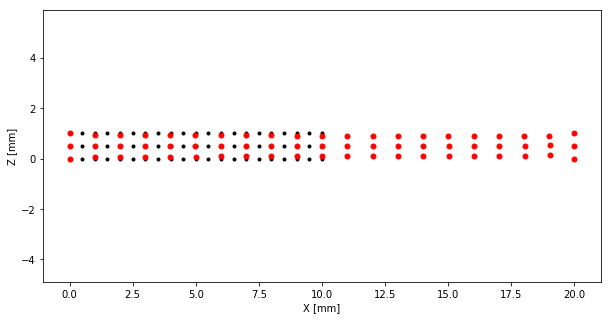

In [19]:
# reset solution
zeros = np.zeros_like(u.vector().get_local())
u.vector().set_local(zeros)

n_steps = 10
max_disp = 10.0 # this must float!!
increment = max_disp/n_steps

disp_guc = [0]
stress_guc = [0]

for i in range(n_steps):
    print('%i/%i, displacement = %f' % (i+1, n_steps,increment*(i+1)))
    r.assign(Constant((increment*(i+1),0.0,0.0)))
    solve(G == 0, u, bcs, J=dG)
    disp_guc.append(increment*(i+1))
    stress_guc.append(get_stress(Z,P))

plot_beam(V,u)

We can now compare the stress behaviour of the different materials. We observe that the neo-Hookean material has a softening behavior, while the stress for the Guccione model starts increasing exponentially.

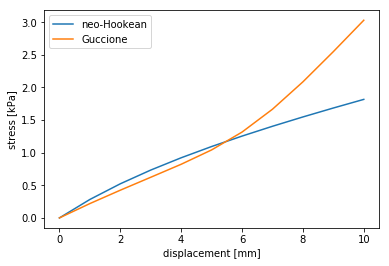

In [20]:
plt.plot(disp_neo,stress_neo, label = 'neo-Hookean')
plt.plot(disp_guc,stress_guc, label = 'Guccione')
plt.xlabel('displacement [mm]')
plt.ylabel('stress [kPa]')
plt.legend(loc = 'upper left')

## Cardiac mechanics benchmark

We will now solve a problem proposed to evaluate the performance of cardiac mechanics codes [2]. Here, we will use the same beam and apply a pressure of 0.004 kPa at the bottom face (z = 0), with the left side clamped. 

<img src="beam_pr.png" width=500>

For simplicity, we will use again a nearly incompressible version of the Guccione model instead of the fully incompressible used in the paper. 

To define the pressure, we define an `Expression` `T`, which is `0` everywhere, except where the z coordinate `x[2]` is zero. Here the expression takes the value of `pressure`. In this way we only apply the pressure at the z = 0 face. To avoid numerial issues when defining the z = 0 face, we `x[2]` to be lower than a very small value called `DOLFIN_EPS`.

To apply the pressure normal to this face, we define `N` as the vector normal to the surface mesh with the function `FacetNormal`. Since the pressure follows the deformation of the beam, we need to update our vector `N` to the current configuration using Nanson's formula $\mathbf{n}da = J\mathbf{F}^{-t}\mathbf{N}dA = {\rm cofactor} (\mathbf{F}) \mathbf{N}dA $. Additionally, a following pressure is non-conservative load, which means that it cannot be derived from a potential energy. That is why we need to add it separately to the residual as `Gext` with the form:
$$G_{ext} = \int_{dS} \mathbf{v}\cdot  {\rm cofactor} (\mathbf{F}) \mathbf{N}dA$$

In the code `ds` represents a surface integral as `dx` represents a volume integral. We can finally define the residual $G = d\Pi + G_{ext}$.

In [21]:
pressure = Constant(0.0)

T = Expression('x[2] < DOLFIN_EPS ? pressure : 0',degree = 2, 
               pressure = pressure)
N = FacetNormal(mesh)
n = cofac(F)*N

Gext = T * inner(v, n) * ds
G = derivative(Pi, u, v) + Gext

dG = derivative(G, u, du)

bcs = [bcl]

With our problem fully defined, we can solve the problem with load stepping again. Here, we will update the `Constant` `pressure` instead of the displacement.

1/10, pressure = 0.000400
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
2/10, pressure = 0.000800
3/10, pressure = 0.001200
4/10, pressure = 0.001600
5/10, pressure = 0.002000
6/10, pressure = 0.002400
7/10, pressure = 0.002800
8/10, pressure = 0.003200
9/10, pressure = 0.003600
10/10, pressure = 0.004000


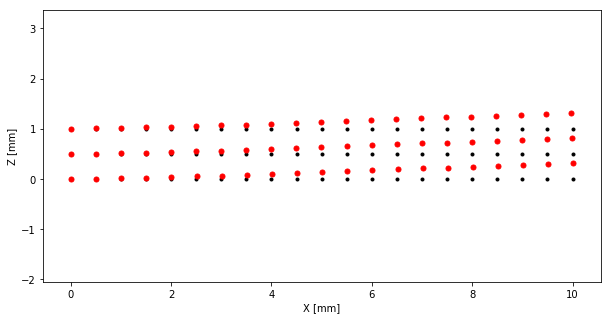

In [22]:
# reset solution
zeros = np.zeros_like(u.vector().get_local())
u.vector().set_local(zeros)

total_force = 0.004
steps = 10
for i in range(steps):
    print('%i/%i, pressure = %f' % (i+1, steps, total_force/steps*(i+1)))
    pressure.assign(total_force/steps*(i+1))
    solve(G == 0, u, bcs, J=dG)

plot_beam(V,u)



## Mesh convergence

Now we can see the influence of the element size on our results. Unfortunately, the number of partitions on the mesh cannot be parameterized with `Constant`. In this case, we define a function that will redefine the entire problem for a given set of partitions `nx,ny,nz`. We will extract the z displacement of the tip of the beam at the point [10.,0.5,1.0] with the helper function `get_disp`.

In [34]:
def refine_benchmark(nx,ny,nz):
    mesh = BoxMesh.create([Point(0.0,0.0,0.0),Point(10.0,1.0,1.0)],[nx,ny,nz],CellType.Type.hexahedron)
    V = VectorFunctionSpace(mesh, "Lagrange", 1)
    Z = TensorFunctionSpace(mesh, 'P', 1) # for stress visualization
    du = TrialFunction(V)            # Incremental displacement
    v  = TestFunction(V)             # Test function
    u  = Function(V)                 # Displacement from previous iteration
    
    F = def_grad(u)
    W = W_guccione(F)
    
    Pi = W*dx 
    
    pressure = Constant(0.0)
    T = Expression('x[2] < DOLFIN_EPS ? pressure : 0',degree = 2, 
                   pressure = pressure)
    N = FacetNormal(mesh)

    Gext = T*inner(v, cofac(F)*N)*ds
    G = derivative(Pi, u, v) + Gext

    dG = derivative(G, u, du)
    
    #boundary condition
    c = Constant((0.0, 0.0, 0.0))
    bcl = DirichletBC(V, c, left)
    bcs = [bcl]

    total_pressure = 0.004
    steps = 10   
    pressures = [0]
    disp = [0]
    for i in range(steps):
        current_pressure = total_force/steps*(i+1) 
        pressure.assign(current_pressure)
        solve(G == 0, u, bcs, J=dG)
        pressures.append(current_pressure)
        disp.append(get_disp(V,u))
    
    plot_beam(V,u)
    return disp, pressures
    
    

We can now run the benchmark for different element sizes of 0.1, 0.125, 0.25 and 0.5 mm and see how the tip displacement changes.

solving 0.5 mm
solving 0.25 mm
solving 0.125 mm
solving 0.1 mm


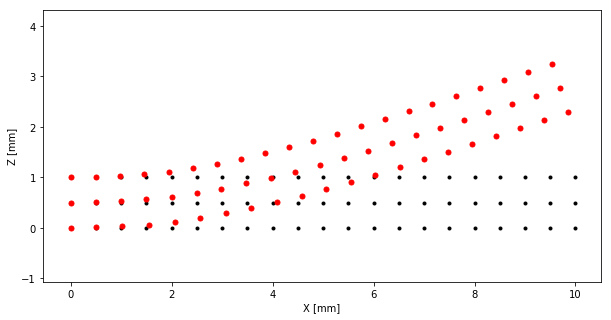

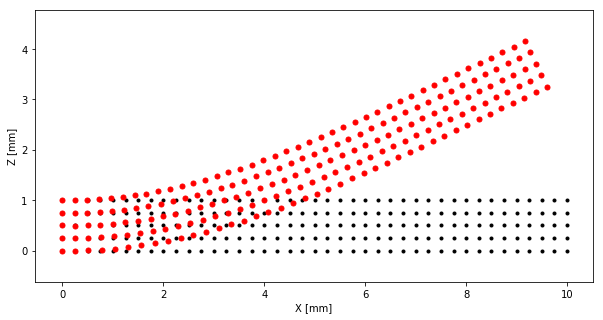

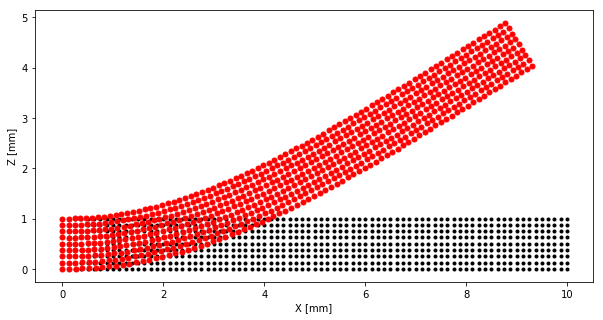

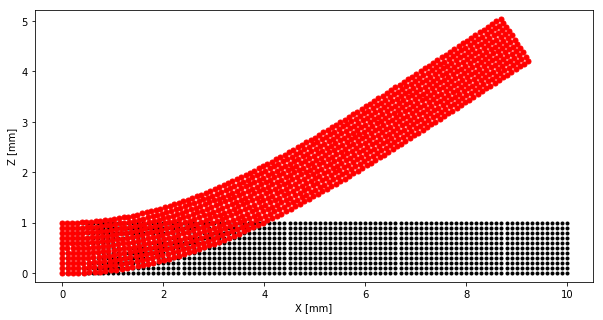

In [35]:
print('solving 0.5 mm')
disp2, pressures2 = refine_benchmark(20,2,2)
print('solving 0.25 mm')
disp4, pressures4 = refine_benchmark(40,4,4)
print('solving 0.125 mm')
disp8, pressures8 = refine_benchmark(80,8,8)
print('solving 0.1 mm')
disp10, pressures10 = refine_benchmark(100,10,10)


Text(0,0.5,'tip displacement [mm]')

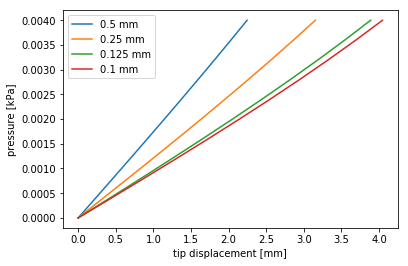

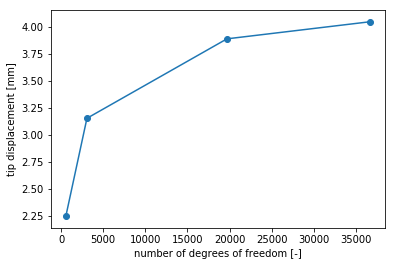

In [36]:
plt.plot(disp2,pressures2, label = '0.5 mm')
plt.plot(disp4,pressures4, label = '0.25 mm')
plt.plot(disp8,pressures8, label = '0.125 mm')
plt.plot(disp10,pressures10, label = '0.1 mm')
plt.legend(loc = 'upper left')
plt.xlabel('tip displacement [mm]')
plt.ylabel('pressure [kPa]')

plt.figure()
plt.scatter([21*3*3*3, 41*5*5*3, 81*9*9*3, 101*11*11*3],[disp2[-1],disp4[-1], disp8[-1], disp10[-1]])
plt.plot([21*3*3*3, 41*5*5*3, 81*9*9*3, 101*11*11*3],[disp2[-1],disp4[-1], disp8[-1], disp10[-1]])
plt.xlabel('number of degrees of freedom [-]')
plt.ylabel('tip displacement [mm]')


We see that the element size had a significant influence in our results. However, the tip displacement converges after using 20000 degrees of freedom (element size 0.125 mm). 

## Additional exercises

1. Change the element type to tetrahedron by changing `CellType.Type.hexahedron` to `CellType.Type.tetrahedron` in the `BoxMesh` function of `refine_mesh`
2. Implement the Holzapfel-Ogden 2009 [3] for cardiac tissue and repeat the benchmark problem. The model has the following strain energy function:

$$W_{ani} = \frac{a}{b} \exp[b(I_1 - 1)] + \frac{a_f}{b_f}\{\exp[b_f(I_{4f} - 1)^2] - 1\} + \frac{a_s}{b_s}\{\exp[b_f(I_{4s} - 1)] - 1\} + \frac{a_{fs}}{b_{fs}}[\exp(b_{fs}I_{8fs}^2) - 1]$$

In this model we consider the fiber $\mathbf{f}_0$, sheet $\mathbf{s}_0$ and normal $\mathbf{n}_0$ directions. For the beam problem, we assign them as $\mathbf{f}_0 = [1,0,0]$, $\mathbf{s}_0 = [0,1,0]$ and $\mathbf{n}_0 = [0,0,1]$. With this, we define the invariants:
$$I_{4f} = \mathbf{f}_0 \cdot \mathbf{C} \mathbf{f}_0$$
$$I_{4s} = \mathbf{s}_0 \cdot \mathbf{C} \mathbf{s}_0$$
$$I_{8fs} = \frac{1}{2}(\mathbf{f}_0 \cdot \mathbf{C} \mathbf{s}_0 + \mathbf{s}_0 \cdot \mathbf{C} \mathbf{f}_0)$$

Consider the same nearly incompressible approach as before and use $\bar{\mathbf{C}}$ to compute the invariants. Use the following parameters:
```
    kappa = 100. # kPa
    
    a = 0.05 # kPa
    b = 2.0 # -
    af = 0.1 # kPa
    bf = 2.0 # -
    a_s = 0.05 # kPa
    bs = 2.0 # -
    afs = 0.01 # kPa
    bfs = 2.0 # -
```


In [77]:
def W_HO(F):
    I = Identity(3)
    J = det(F)
    C = pow(J, -float(2)/3) * F.T*F

    kappa = Constant(100.0, name = 'kappa')
    
    a = 0.05
    b = 2.0
    af = 0.1
    bf = 2.0
    a_s = 0.05
    bs = 2.0
    afs = 0.01
    bfs = 2.0
    
    f0 = as_vector([1.0,0.0,0.0])
    s0 = as_vector([0.0,1.0,0.0])
    n0 = as_vector([0.0,0.0,1.0])
    
    I1 = tr(C)
    I4f = inner(f0, C*f0)
    I4s = inner(s0, C*s0)
    I8fs = 0.5*(inner(f0, C*s0) + inner(s0, C*f0))

    Wani = a/b*exp(b*(I1-1)) + af/bf*exp(bf*(I4f - 1)**2) + a_s/bs*exp(bs*(I4s - 1)**2) + afs/bfs*exp(bfs*I8fs**2)
    Winc = kappa * (J**2 - 1 - 2*ln(J))

    return Wani + Winc

In [78]:
def refine_benchmark(nx,ny,nz):
    mesh = BoxMesh.create([Point(0.0,0.0,0.0),Point(10.0,1.0,1.0)],[nx,ny,nz],CellType.Type.hexahedron)
    V = VectorFunctionSpace(mesh, "Lagrange", 1)
    Z = TensorFunctionSpace(mesh, 'P', 1) # for stress visualization
    du = TrialFunction(V)            # Incremental displacement
    v  = TestFunction(V)             # Test function
    u  = Function(V)                 # Displacement from previous iteration
    
    F = def_grad(u)
    W = W_HO(F)
    
    Pi = W*dx 
    
    pressure = Constant(0.0)
    T = Expression('x[2] < DOLFIN_EPS ? pressure : 0',degree = 2, 
                   pressure = pressure)
    N = FacetNormal(mesh)

    Gext = T*inner(v, cofac(F)*N)*ds
    G = derivative(Pi, u, v) + Gext

    dG = derivative(G, u, du)
    
    #boundary condition
    c = Constant((0.0, 0.0, 0.0))
    bcl = DirichletBC(V, c, left)
    bcs = [bcl]

    total_pressure = 0.004
    steps = 10   
    pressures = [0]
    disp = [0]
    for i in range(steps):
        current_pressure = total_force/steps*(i+1) 
        pressure.assign(current_pressure)
        solve(G == 0, u, bcs, J=dG)
        pressures.append(current_pressure)
        disp.append(get_disp(V,u))
    
    plot_beam(V,u)
    return disp, pressures

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


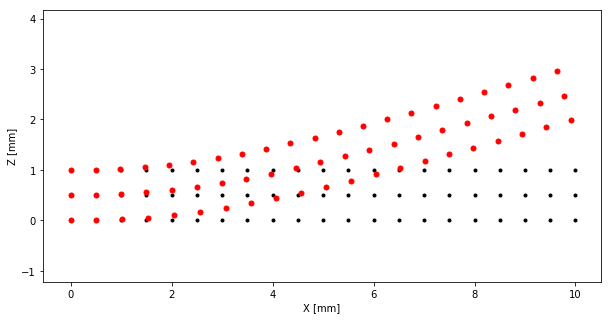

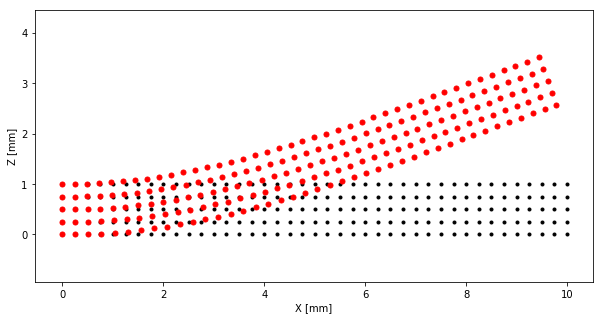

In [79]:
disp2, pressures2 = refine_benchmark(20,2,2)
disp4, pressures4 = refine_benchmark(40,4,4)

In [80]:
disp4

[0,
 0.25939086166812347,
 0.51786848471214475,
 0.77506439992423726,
 1.0306148490531295,
 1.2841625114822852,
 1.5353581662269844,
 1.7838622716346213,
 2.0293464467763811,
 2.2714948404107256,
 2.5100053755226805]

## References

[1] Guccione, Julius M., Kevin D. Costa, and Andrew D. McCulloch. "Finite element stress analysis of left ventricular mechanics in the beating dog heart." Journal of biomechanics 28, no. 10 (1995): 1167-1177.

[2] Land, Sander, Viatcheslav Gurev, Sander Arens, Christoph M. Augustin, Lukas Baron, Robert Blake, Chris Bradley et al. "Verification of cardiac mechanics software: benchmark problems and solutions for testing active and passive material behaviour." Proc. R. Soc. A 471, no. 2184 (2015): 20150641.

[3] Holzapfel, Gerhard A., and Ray W. Ogden. "Constitutive modelling of passive myocardium: a structurally based framework for material characterization." Philosophical Transactions of the Royal Society of London A: Mathematical, Physical and Engineering Sciences 367, no. 1902 (2009): 3445-3475.